In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as ud
from torchvision import datasets, transforms

from enum import Enum

import matplotlib.pyplot as plt
%matplotlib inline

# If quicktest is set, running each notebook section prints something
Quicktest = True

def plot_single(img, label):
    fig = plt.figure
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

# An obvious extension is to support image formats other than
# the MNIST 28x28 byte per pixel gray scale.
IMG_DIM = 28 # Images are 28x28
IMG_SIZE = IMG_DIM*IMG_DIM

# Another extension is support classification to other than
# just 10 categories, but this is enough for MNIST and KMNIST.
OUT_SIZE = 10 # Image elements are one of 10 digits

Mode = Enum('Mode', ['TRAIN', 'EVALUATE'])

# store all the things (hyperparameters)
class Hyper():
    def __init__(self):
        self.cache = "./data" # Pytorch caches data in subdirectory (ies)
        self.mbsize = 32 # minibatch size
        self.tstsize = 1000 # test batch size
        self.hl_1_size = 64 # hidden layer 1 neurons
        self.hl_2_size = 32 # hidden layer 2 neurons

hp = Hyper()

if Quicktest == True:
    print(f"mini-batch size: {hp.mbsize}")

mini-batch size: 32


Hiragana: <class 'int'> torch.Size([32, 1, 28, 28]) torch.Size([32])


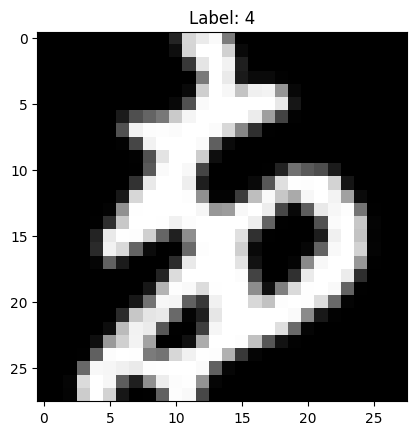

English <class 'int'> torch.Size([32, 1, 28, 28]) torch.Size([32])


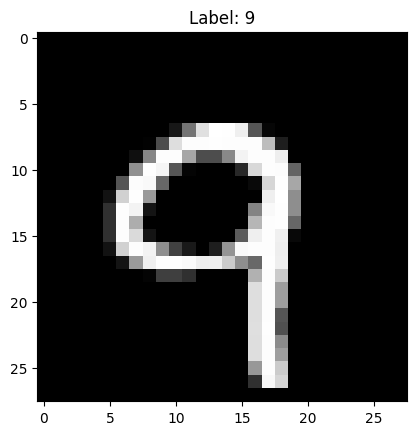

In [2]:
class DataHolder():
    def __init__(self, loader, cache=hp.cache, size=hp.mbsize, test_size=hp.tstsize):
        self.train = loader(root=cache, train=True, download=True,
                            transform=transforms.ToTensor())
        self.test = loader(root=cache, train=False, download=True,
                            transform=transforms.ToTensor())
        self.mode = Mode.TRAIN
        self.size = size
        self.test_size = test_size
    
    def __iter__(self):
        if self.mode == Mode.TRAIN:
            self.loader = ud.DataLoader(self.train, batch_size=self.size, shuffle=True)
        else: # EVALUATE
            self.loader = ud.DataLoader(self.test, batch_size=self.test_size, shuffle=False)
        return enumerate(self.loader)

    def __next__(self):
        return next(self.loader)

if Quicktest == True:
    qk = DataHolder(datasets.KMNIST)
    qm = DataHolder(datasets.MNIST)

    for i, (data, target) in qk:
        print("Hiragana:", type(i), data.shape, target.shape)
        plot_single(data[0, 0], target[0])
        break
    
    for i, (data, target) in qm:
        print("English", type(i), data.shape, target.shape)
        plot_single(data[0, 0], target[0])
        break


In [3]:
# Define the MLP model
class MLP(nn.Module):
    # (self, nn loss class, nn optimizer class)
    def __init__(self, criterion, optimizer):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(IMG_SIZE, hp.hl_1_size))
        self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(hp.hl_1_size, hp.hl_2_size))
        self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(hp.hl_2_size, OUT_SIZE))
        self.criterion = criterion()
        self.optimizer = optimizer(self.parameters())
        self.data = None

    def forward(self, x):
        x = x.view(-1, IMG_SIZE)
        for layer in self.layers:
            x = layer(x)
        return x

    def set_data(self, data):
        self.data = data

    def epoch(self):
        if self.data == None:
            raise Exception("call set_data before training")
        self.data.mode = Mode.TRAIN
        loss = None
        for i, (batch, target) in self.data:  
            self.optimizer.zero_grad()
            result = self.forward(batch)
            loss = self.criterion(result, target)
            loss.backward()
            self.optimizer.step()
        if torch.is_tensor(loss):
            print(f"training: loss = {loss.item()}")   

    def evaluate(self):
        if self.data == None:
            raise Exception("call set_data before training")
        self.data.mode = Mode.EVALUATE
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (batch, target) in self.data:
                output = self.forward(batch)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        print('Accuracy: %f' % (100 * correct / total))   

if (Quicktest == True):
    mlp = MLP(nn.CrossEntropyLoss, optim.Adam)
    print(mlp)
    print(mlp.optimizer)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [4]:
# Train on MNIST
mlp = MLP(nn.CrossEntropyLoss, optim.Adam)
mlp.set_data(DataHolder(datasets.MNIST))
for ep in range(5):
    mlp.epoch()

training: loss = 0.5959852337837219
training: loss = 0.15534624457359314
training: loss = 0.04703182354569435
training: loss = 0.029073921963572502
training: loss = 0.029344456270337105


In [5]:
# Evaluate after initial training
mlp.evaluate()

Accuracy: 97.090000


In [6]:
# Now train on KMNIST (Hiragana digits 0..9)
mlp.set_data(DataHolder(datasets.KMNIST))
for ep in range(5):
    mlp.epoch()

training: loss = 0.26545003056526184
training: loss = 0.19477340579032898
training: loss = 0.3085419237613678
training: loss = 0.23180727660655975
training: loss = 0.12639132142066956


In [7]:
# Evaluate KMNIST after retraining ...
mlp.evaluate()

Accuracy: 83.690000


In [8]:
# ... KMNIST is hard. Now, re-evaluate goodness at MNIST (was 96.4%)
mlp.set_data(DataHolder(datasets.MNIST))
mlp.evaluate()

Accuracy: 9.970000
